In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

import shutil

In [5]:
root_dir = './animales/raw-img/'

images_per_folder = {}

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        images_per_folder[folder] = num_images

for folder, num_images in images_per_folder.items():
    print(f"Carpeta: {folder}, Cantidad de imágenes: {num_images}")


Carpeta: cane, Cantidad de imágenes: 4863
Carpeta: cavallo, Cantidad de imágenes: 2623
Carpeta: elefante, Cantidad de imágenes: 1446
Carpeta: farfalla, Cantidad de imágenes: 2112
Carpeta: gallina, Cantidad de imágenes: 3098
Carpeta: gatto, Cantidad de imágenes: 1668
Carpeta: mucca, Cantidad de imágenes: 1866
Carpeta: pecora, Cantidad de imágenes: 1820
Carpeta: ragno, Cantidad de imágenes: 4821
Carpeta: scoiattolo, Cantidad de imágenes: 1862


In [9]:
root_dir = './raw-img/'

# Obtener una lista de todas las carpetas en el directorio raíz
folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

# Crear listas para almacenar las rutas de las imágenes de entrenamiento y prueba
train_dataset = []
test_dataset = []

# Iterar sobre cada carpeta
for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    # Obtener la lista de imágenes en la carpeta
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))]
    # Dividir las imágenes en train y test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    # Agregar las imágenes divididas a los conjuntos de entrenamiento y prueba
    train_dataset.extend([(img_path, folder) for img_path in train_images])
    test_dataset.extend([(img_path, folder) for img_path in test_images])

# Crear directorios para el conjunto de entrenamiento y el conjunto de prueba
train_dir = 'train_dataset'
test_dir = 'test_dataset'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [12]:
# Copiar imágenes al directorio de entrenamiento y prueba
for dataset, dataset_dir in [(train_dataset, train_dir), (test_dataset, test_dir)]:
    for img_path, label in dataset:
        # Obtener la ruta de la carpeta de destino para esta imagen
        target_folder = os.path.join(dataset_dir, label)
        # Crear la carpeta si no existe
        os.makedirs(target_folder, exist_ok=True)
        # Copiar la imagen al directorio correspondiente
        shutil.copy(img_path, target_folder)

In [6]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [14]:
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# Crear conjuntos de datos ImageFolder
train_set = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(test_dir, transform=data_transforms)

# Crear DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [22]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                   [-1, 10]           5,130
Total params: 5,411,498
Trainable params: 5,411,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.64
Estima

In [24]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    test_loader = data["test"]

    train_writer = tb_writer["train"]
    test_writer = tb_writer["test"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        test_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_test_loss = 0.0
        epoch_test_accuracy = 0.0

        for test_data, test_target in test_loader:
            if torch.cuda.is_available():
                test_data = test_data.to("cuda")
                test_target = test_target.to("cuda")

            output = model(test_data.float())
            epoch_test_loss += criterion(output, test_target).item()
            epoch_test_accuracy += metric(output, test_target).item()

        epoch_test_loss = epoch_test_loss / len(test_loader)
        epoch_test_accuracy = epoch_test_accuracy / len(test_loader)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - test Loss {:.6f} - test Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_test_loss, epoch_test_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            test_writer.add_scalar("loss", epoch_test_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            test_writer.add_scalar("accuracy", epoch_test_accuracy, epoch)
            train_writer.flush()
            test_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = test_loss
    history["valid_acc"] = test_acc

    return history

In [17]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.0001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "test": test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "test": SummaryWriter(log_dir="data_aug/noaug_test")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                noaug_writer)

Epoch: 1/20 - Train loss 1.966522 - Train Accuracy 0.296231 - test Loss 1.736423 - test Accuracy 0.387188
Epoch: 2/20 - Train loss 1.653569 - Train Accuracy 0.428464 - test Loss 1.582197 - test Accuracy 0.442195
Epoch: 3/20 - Train loss 1.514332 - Train Accuracy 0.481250 - test Loss 1.535006 - test Accuracy 0.466311
Epoch: 4/20 - Train loss 1.417305 - Train Accuracy 0.515067 - test Loss 1.456741 - test Accuracy 0.491441
Epoch: 5/20 - Train loss 1.337701 - Train Accuracy 0.546002 - test Loss 1.370114 - test Accuracy 0.531395
Epoch: 6/20 - Train loss 1.264379 - Train Accuracy 0.570544 - test Loss 1.293256 - test Accuracy 0.555869
Epoch: 7/20 - Train loss 1.192777 - Train Accuracy 0.597996 - test Loss 1.246918 - test Accuracy 0.573811
Epoch: 8/20 - Train loss 1.120251 - Train Accuracy 0.622290 - test Loss 1.176899 - test Accuracy 0.598880
Epoch: 9/20 - Train loss 1.054394 - Train Accuracy 0.646870 - test Loss 1.155194 - test Accuracy 0.607020
Epoch: 10/20 - Train loss 0.988849 - Train Acc

In [18]:
PATH = "./model/naug_conv_model.pt"
torch.save(noaug_conv_model, PATH)

In [20]:
import json
HISTORY_FILE_PATH = "./output/history.json"
# Writing dictionary to JSON file
with open(HISTORY_FILE_PATH, 'w') as json_file:
    json.dump(history, json_file)

## Aplicar Data Augmentation

In [26]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(train_dir, transform=aug_data_transforms)
aug_test_set = torchvision.datasets.ImageFolder(test_dir, transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_test_loader = torch.utils.data.DataLoader(aug_test_set, batch_size=32, shuffle=True)

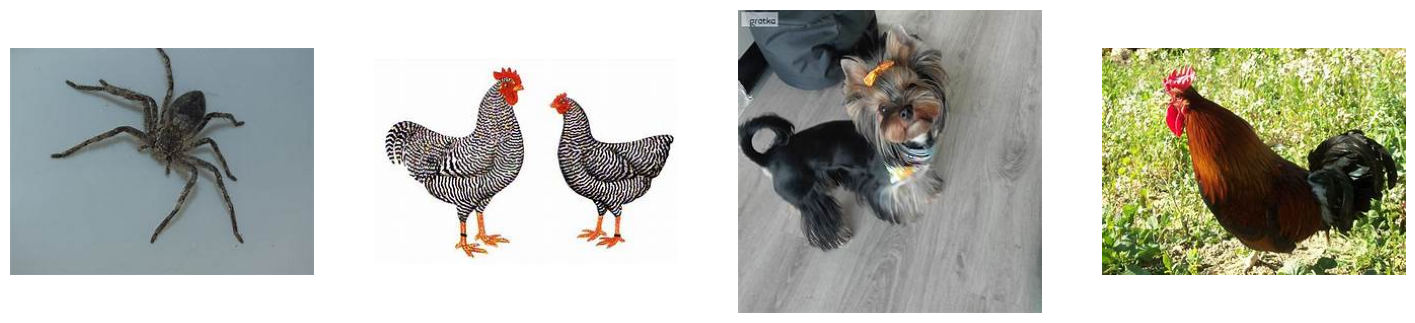

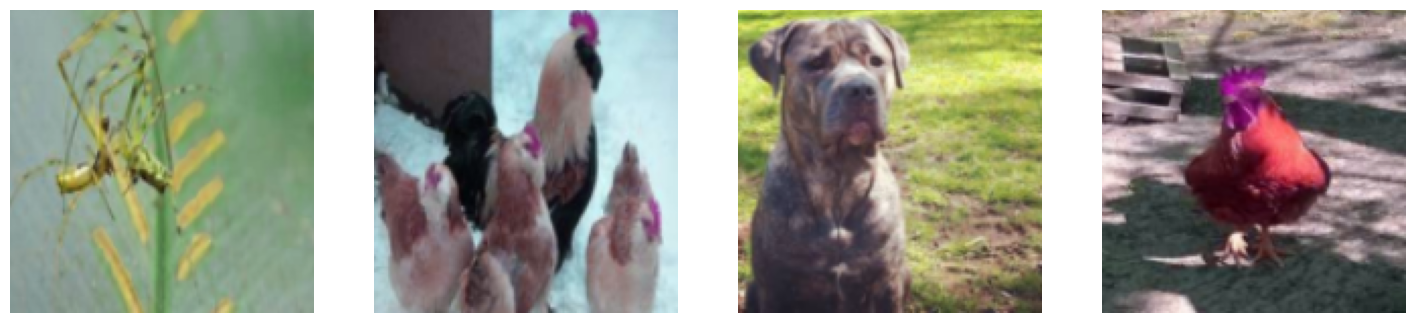

In [27]:
images_ids = np.random.randint(low=0, high=len(train_dataset), size=4)

# Ploteo las imágenes sin augmentación
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    img_path, label = train_dataset[images_ids[id]]
    img = Image.open(img_path)
    row.imshow(img)
    row.axis('off')
plt.show()

# Ploteo las imágenes con data augmentation
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    img, label = aug_train_set[images_ids[id]]
    # No es necesario realizar ninguna manipulación de las dimensiones aquí
    row.imshow(img.permute(1, 2, 0))
    row.axis('off')
plt.show()


In [28]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "test": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "test": SummaryWriter(log_dir="data_aug/aug_test")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                50,
                aug_writer)

KeyboardInterrupt: 